# ОИАД. Лабораторная работа №3

Для построения моделей: datasets/insurance_train.csv
Для оценки обобщающей способности: datasets/insurance_test.csv

Инфо о датасете: https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## 1. Подготовка данных

In [134]:
# Загрузка данных
train_data = pd.read_csv('../datasets/insurance_train.csv')
test_data = pd.read_csv('../datasets/insurance_test.csv')

print("Размер обучающей выборки:", train_data.shape)
print("Размер тестовой выборки:", test_data.shape)
print("\nПервые 5 строк обучающей выборки:")
train_data.head()

Размер обучающей выборки: (338, 7)
Размер тестовой выборки: (1000, 7)

Первые 5 строк обучающей выборки:


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


In [135]:
print("Описание признаков:")

comparison_info = pd.concat({
    'TRAIN': pd.DataFrame({
        'dtype': train_data.dtypes,
        'non_null': train_data.count(),
        'null': train_data.isnull().sum()
    }),
    'TEST': pd.DataFrame({
        'dtype': test_data.dtypes,
        'non_null': test_data.count(),
        'null': test_data.isnull().sum()
    })
}, axis=1)

print(comparison_info)

Описание признаков:
            TRAIN                   TEST              
            dtype non_null null    dtype non_null null
age         int64      338    0    int64     1000    0
sex        object      338    0   object     1000    0
bmi       float64      338    0  float64     1000    0
children    int64      338    0    int64     1000    0
smoker     object      338    0   object     1000    0
region     object      338    0   object     1000    0
charges   float64      338    0  float64     1000    0


In [136]:
print("Статистика по числовым признакам (сравнение train/test):")
print("=" * 70)

for col in train_data.select_dtypes(include=[np.number]).columns:
    print(f"\n {col.upper()}:")
    stats_df = pd.DataFrame({
        'TRAIN': train_data[col].describe(),
        'TEST': test_data[col].describe()
    })
    print(stats_df)
    print("-" * 40)

Статистика по числовым признакам (сравнение train/test):

 AGE:
            TRAIN         TEST
count  338.000000  1000.000000
mean    38.810651    39.341000
std     13.637734    14.190775
min     18.000000    18.000000
25%     27.000000    26.000000
50%     38.000000    40.000000
75%     50.000000    52.000000
max     64.000000    64.000000
----------------------------------------

 BMI:
            TRAIN         TEST
count  338.000000  1000.000000
mean    30.672751    30.660235
std      6.309709     6.028243
min     17.290000    15.960000
25%     26.053750    26.400000
50%     30.065000    30.495000
75%     34.595000    34.700000
max     53.130000    52.580000
----------------------------------------

 CHILDREN:
            TRAIN         TEST
count  338.000000  1000.000000
mean     1.153846     1.075000
std      1.205822     1.205333
min      0.000000     0.000000
25%      0.000000     0.000000
50%      1.000000     1.000000
75%      2.000000     2.000000
max      5.000000     5.00000

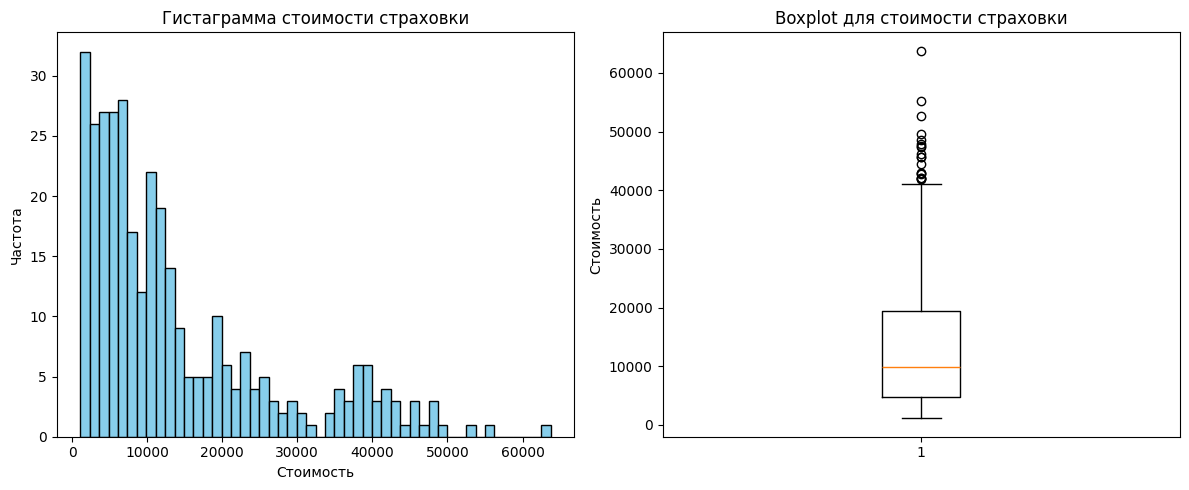

In [137]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['charges'], bins=50, color='skyblue', edgecolor='black')
plt.title('Гистаграмма стоимости страховки')
plt.xlabel('Стоимость')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.boxplot(train_data['charges'])
plt.title('Boxplot для стоимости страховки')
plt.ylabel('Стоимость')

plt.tight_layout()
plt.show()

In [ ]:
# Создание копий данных для обработки
train_processed = train_data.copy()
test_processed = test_data.copy()

# Кодирование бинарных категориальных признаков
train_processed['sex'] = train_processed['sex'].map({'female': 0, 'male': 1})
train_processed['smoker'] = train_processed['smoker'].map({'no': 0, 'yes': 1})
test_processed['sex'] = test_processed['sex'].map({'female': 0, 'male': 1})
test_processed['smoker'] = test_processed['smoker'].map({'no': 0, 'yes': 1})

# Кодирование категориального признака 'region' с помощью one-hot encoding
train_processed = pd.get_dummies(train_processed, columns=['region'], prefix='region', drop_first=True, dtype=int)
test_processed = pd.get_dummies(test_processed, columns=['region'], prefix='region', drop_first=True,  dtype=int)

print("Структура обработанных данных:")
print(train_processed.head())
print("\nПризнаки после обработки:\n", list(train_processed.columns))

Структура обработанных данных:
   age  sex     bmi  children  smoker      charges  region_northeast  \
0   26    1  27.060         0       1  17043.34140                 0   
1   58    1  36.955         2       1  47496.49445                 0   
2   20    0  24.420         0       1  26125.67477                 0   
3   51    0  38.060         0       1  44400.40640                 0   
4   62    0  25.000         0       0  13451.12200                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 1                 0                 0  
2                 0                 1                 0  
3                 0                 1                 0  
4                 0                 0                 1  

Признаки после обработки:
 ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']


In [139]:
print("Описание обработанных признаков:")
train_processed.info()

Описание обработанных признаков:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               338 non-null    int64  
 1   sex               338 non-null    int64  
 2   bmi               338 non-null    float64
 3   children          338 non-null    int64  
 4   smoker            338 non-null    int64  
 5   charges           338 non-null    float64
 6   region_northeast  338 non-null    int64  
 7   region_northwest  338 non-null    int64  
 8   region_southeast  338 non-null    int64  
 9   region_southwest  338 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 26.5 KB


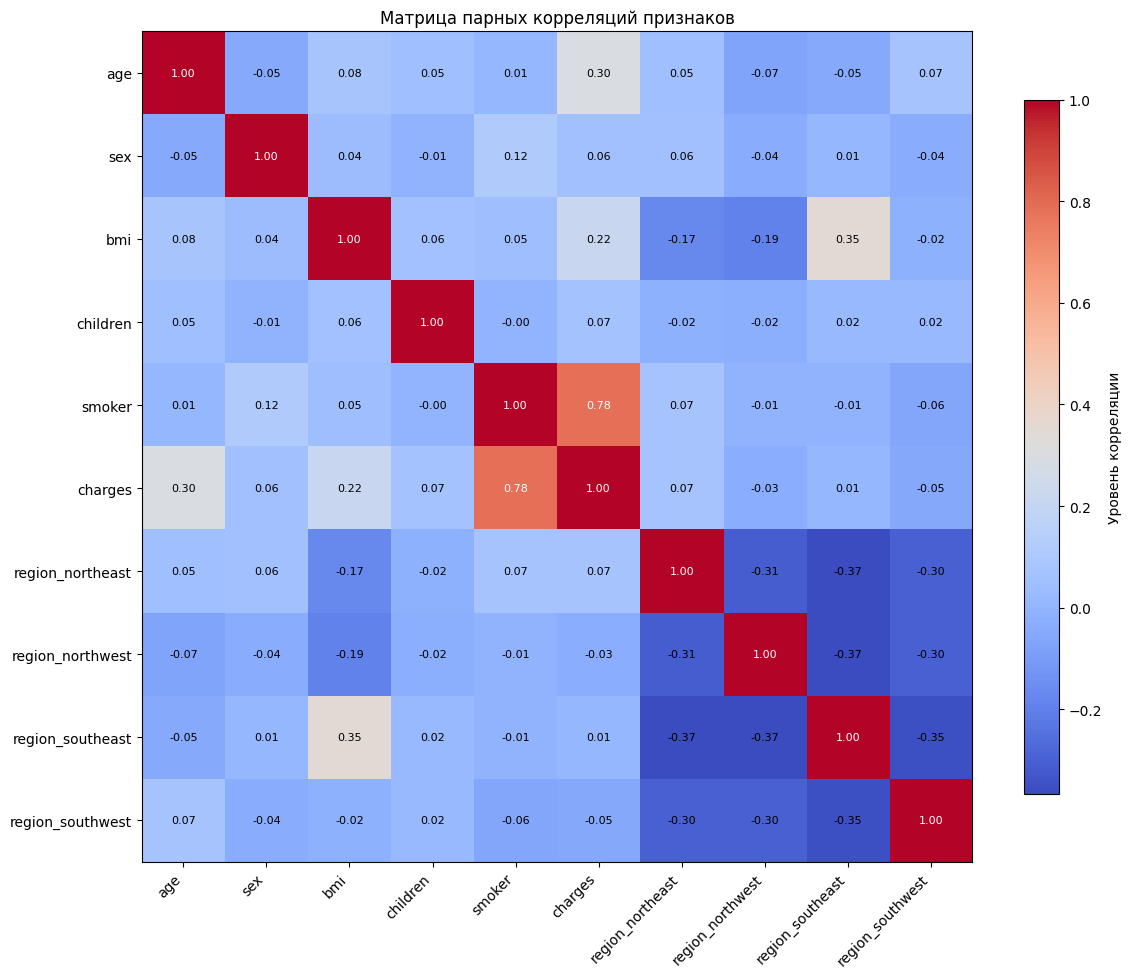

Корреляции с целевой переменной 'charges':
charges             1.000000
smoker              0.783519
age                 0.298395
bmi                 0.219566
region_northeast    0.074659
children            0.069444
sex                 0.060221
region_southeast    0.009792
region_northwest   -0.032287
region_southwest   -0.053905
Name: charges, dtype: float64


In [140]:
# Вычисление парных корреляций признаков
correlation_matrix = train_processed.corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Создание heatmap
im = ax.imshow(correlation_matrix, cmap='coolwarm')

# Добавление цветовой шкалы
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Уровень корреляции')

# Настройка осей
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_yticklabels(correlation_matrix.columns)

# Добавление подписей значений
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
               ha='center', va='center', 
               fontsize=8,
               color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

ax.set_title('Матрица парных корреляций признаков')
plt.tight_layout()
plt.show()

# Вывод корреляций с целевой переменной
target_corr = correlation_matrix['charges'].sort_values(ascending=False)
print("Корреляции с целевой переменной 'charges':")
print(target_corr)

## 2. Многомерная линейная регрессия

In [141]:
# Разделение на признаки и целевую переменную
X_train = train_processed.drop('charges', axis=1)
y_train = train_processed['charges']
X_test = test_processed.drop('charges', axis=1)
y_test = test_processed['charges']

# Добавление столбца единиц для учета свободного члена
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test.values])

print("Размерность обучающих данных:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Размерность обучающих данных:
X_train: (338, 10)
y_train: (338,)
X_test: (1000, 10)
y_test: (1000,)


In [142]:
# Аналитическое решение линейной регрессии 
def linear_regression_analytical(X, y):
    """
    Аналитическое решение линейной регрессии: w = (X^T * X)^(-1) * X^T * y
    """
    weights = np.linalg.pinv(X.T @ X) @ X.T @ y
    return weights

# Обучение модели
w_analytical = linear_regression_analytical(X_train, y_train)
print("Веса модели (аналитическое решение):")
feature_names = ['bias'] + list(train_processed.drop('charges', axis=1).columns)
for i, (name, weight) in enumerate(zip(feature_names, w_analytical)):
    print(f"{name}: {weight:.4f}")

Веса модели (аналитическое решение):
bias: -9772.6042
age: 256.7107
sex: -655.4050
bmi: 350.8639
children: 483.1042
smoker: 23401.9926
region_northeast: -1685.4035
region_northwest: -1885.9904
region_southeast: -3075.2992
region_southwest: -3125.9111


In [143]:
# Предсказания аналитической модели
y_pred_analytical_train = X_train @ w_analytical
y_pred_analytical_test = X_test @ w_analytical

print("Аналитическая модель:")
print(f"MSE на обучающей выборке: {mean_squared_error(y_train, y_pred_analytical_train):.2f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_analytical_test):.2f}")

Аналитическая модель:
MSE на обучающей выборке: 44325092.03
MSE на тестовой выборке: 34216008.76


In [144]:
# Численное решение с помощью градиентного спуска
def gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
    # Инициализация весов нулями
    n_features = X.shape[1]
    weights = np.zeros(n_features)
    
    for i in range(n_iterations):
        y_pred = X @ weights
        
        # Вычисление градиента
        gradient = -2 * X.T @ (y - y_pred) / len(y)
        
        # Обновление весов
        new_weights = weights - learning_rate * gradient
        
        # Проверка условия останова
        if np.linalg.norm(new_weights - weights) < tolerance:
            break
            
        weights = new_weights
    
    return weights

# Нормализация признаков для лучшей сходимости градиентного спуска
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:, 1:])  # Исключаем столбец единиц
X_train_scaled = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])

X_test_scaled = scaler.transform(X_test[:, 1:])  # Исключаем столбец единиц
X_test_scaled = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

# Обучение модели градиентным спуском
w_gd = gradient_descent(X_train_scaled, y_train.values, 
                                    learning_rate=0.01, n_iterations=5000)

print("Веса модели (градиентный спуск):")
for i, (name, weight) in enumerate(zip(feature_names, w_gd)):
    print(f"{name}: {weight:.4f}")

Веса модели (градиентный спуск):
bias: 14092.8619
age: 3495.7695
sex: -327.4213
bmi: 2210.5718
children: 581.6751
smoker: 9859.8455
region_northeast: 330.4167
region_northwest: 245.1576
region_southeast: -281.1699
region_southwest: -276.8529


In [145]:
# Предсказания модели градиентного спуска
y_pred_gd_train = X_train_scaled @ w_gd
y_pred_gd_test = X_test_scaled @ w_gd

print("Модель градиентного спуска:")
print(f"MSE на обучающей выборке: {mean_squared_error(y_train, y_pred_gd_train):.2f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_gd_test):.2f}")

Модель градиентного спуска:
MSE на обучающей выборке: 44325092.03
MSE на тестовой выборке: 34216008.79


## 3. Добавление регуляризации

In [146]:
# Аналитическое решение с L2-регуляризацией (гребневая регрессия)
def ridge_regression_analytical(X, y, alpha=1.0):
    """
    Аналитическое решение гребневой регрессии:
    w = (X^T * X + alpha * I)^(-1) * X^T * y
    """
    n_features = X.shape[1]
    # Матрица регуляризации (нулевой вес для свободного члена)
    reg_matrix = alpha * np.eye(n_features)
    reg_matrix[0, 0] = 0  # Не регуляризуем свободный член
    
    # Решение с регуляризацией
    weights = np.linalg.inv(X.T @ X + reg_matrix) @ X.T @ y
    return weights

# Подбор оптимального параметра регуляризации
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
mse_scores = []

for alpha in alphas:
    w_ridge = ridge_regression_analytical(X_train, y_train.values, alpha)
    y_pred_ridge = X_test @ w_ridge
    mse = mean_squared_error(y_test, y_pred_ridge)
    mse_scores.append(mse)
    print(f"Alpha: {alpha}, MSE: {mse:.2f}")

# Выбор наилучшего alpha
best_alpha_idx = np.argmin(mse_scores)
best_alpha = alphas[best_alpha_idx]
print(f"\nОптимальный alpha: {best_alpha}")

# Обучение модели с оптимальным alpha
w_ridge = ridge_regression_analytical(X_train, y_train.values, best_alpha)
print("\nВеса модели (гребневая регрессия):")
for i, (name, weight) in enumerate(zip(feature_names, w_ridge)):
    print(f"{name}: {weight:.4f}")

Alpha: 0.1, MSE: 34224410.09
Alpha: 1.0, MSE: 34320890.02
Alpha: 10.0, MSE: 36762197.90
Alpha: 100.0, MSE: 71447862.68
Alpha: 1000.0, MSE: 116181602.26

Оптимальный alpha: 0.1

Веса модели (гребневая регрессия):
bias: -12213.1598
age: 256.7254
sex: -650.8213
bmi: 350.9870
children: 482.9760
smoker: 23362.1714
region_northeast: 759.0305
region_northwest: 556.6791
region_southeast: -632.1590
region_southwest: -683.5505


In [147]:
# Предсказания гребневой регрессии
y_pred_ridge_train = X_train @ w_ridge
y_pred_ridge_test = X_test @ w_ridge

print("Гребневая регрессия:")
print(f"MSE на обучающей выборке: {mean_squared_error(y_train, y_pred_ridge_train):.2f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_ridge_test):.2f}")

Гребневая регрессия:
MSE на обучающей выборке: 44325367.78
MSE на тестовой выборке: 34224410.09


In [148]:
# Численное решение с регуляризацией (градиентный спуск с L2)
def ridge_gradient_descent(X, y, alpha=1.0, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
    n_features = X.shape[1]
    weights = np.zeros(n_features)
    
    for i in range(n_iterations):
        # Предсказания
        y_pred = X @ weights

        
        # Вычисление градиента с регуляризацией
        gradient = -2 * X.T @ (y - y_pred) / len(y)
        # Добавляем градиент регуляризации (для всех весов кроме bias)
        reg_gradient = np.zeros_like(weights)
        reg_gradient[1:] = 2 * alpha * weights[1:]
        gradient += reg_gradient
        
        # Обновление весов
        new_weights = weights - learning_rate * gradient
        
        # Проверка условия останова
        if np.linalg.norm(new_weights - weights) < tolerance:
            break
            
        weights = new_weights
    
    return weights

# Обучение модели градиентным спуском с регуляризацией
w_ridge_gd = ridge_gradient_descent(X_train_scaled, y_train.values, 
                                                       alpha=best_alpha, learning_rate=0.01, 
                                                       n_iterations=5000)

print("Веса модели (градиентный спуск с регуляризацией):")
for i, (name, weight) in enumerate(zip(feature_names, w_ridge_gd)):
    print(f"{name}: {weight:.4f}")

Веса модели (градиентный спуск с регуляризацией):
bias: 14092.8619
age: 3202.3041
sex: -211.2261
bmi: 2048.2803
children: 551.1344
smoker: 8960.2364
region_northeast: 341.5260
region_northwest: 189.9698
region_southeast: -240.0044
region_southwest: -277.2376


In [149]:
# Предсказания модели градиентного спуска с регуляризацией
y_pred_ridge_gd_train = X_train_scaled @ w_ridge_gd
y_pred_ridge_gd_test = X_test_scaled @ w_ridge_gd

print("Гребневая регрессия (градиентный спуск):")
print(f"MSE на обучающей выборке: {mean_squared_error(y_train, y_pred_ridge_gd_train):.2f}")
print(f"MSE на тестовой выборке: {mean_squared_error(y_test, y_pred_ridge_gd_test):.2f}")

Гребневая регрессия (градиентный спуск):
MSE на обучающей выборке: 45264165.31
MSE на тестовой выборке: 35408853.14


## 4. Оценка обобщающей способности

In [150]:
# Константная модель (прогноз средним значением)
y_mean = np.mean(y_train)
y_pred_mean_train = np.full_like(y_train, y_mean)
y_pred_mean_test = np.full_like(y_test, y_mean)

mse_mean_train = mean_squared_error(y_train, y_pred_mean_train)
mse_mean_test = mean_squared_error(y_test, y_pred_mean_test)

print("Константная модель (среднее значение):")
print(f"Среднее значение: {y_mean:.2f}")
print(f"MSE на обучающей выборке: {mse_mean_train:.2f}")
print(f"MSE на тестовой выборке: {mse_mean_test:.2f}")

Константная модель (среднее значение):
Среднее значение: 14092.86
MSE на обучающей выборке: 163163194.57
MSE на тестовой выборке: 141830094.36


In [151]:
# Сравнение моделей
models = [
    ('Константная модель', mse_mean_test),
    ('Линейная регрессия (аналитическая)', mean_squared_error(y_test, y_pred_analytical_test)),
    ('Линейная регрессия (градиентный спуск)', mean_squared_error(y_test, y_pred_gd_test)),
    ('Гребневая регрессия (аналитическая) c регуляризацией', mean_squared_error(y_test, y_pred_ridge_test)),
    ('Гребневая регрессия (градиентный спуск) c регуляризацией', mean_squared_error(y_test, y_pred_ridge_gd_test))
]

print("Сравнение моделей по MSE на тестовой выборке:")
print("-" * 50)
for name, mse in sorted(models, key=lambda x: x[1]):
    print(f"{name:<40}: {np.sqrt(mse):>15.2f}")

Сравнение моделей по MSE на тестовой выборке:
--------------------------------------------------
Линейная регрессия (аналитическая)      :         5849.45
Линейная регрессия (градиентный спуск)  :         5849.45
Гребневая регрессия (аналитическая) c регуляризацией:         5850.16
Гребневая регрессия (градиентный спуск) c регуляризацией:         5950.53
Константная модель                      :        11909.24


In [152]:
# 4.2 Сравнение моделей
models = [
    ('Константная модель', mse_mean_train),
    ('Линейная регрессия (аналитическая)', mean_squared_error(y_train, y_pred_analytical_train)),
    ('Линейная регрессия (градиентный спуск)', mean_squared_error(y_train, y_pred_gd_train)),
    ('Гребневая регрессия (аналитическая) c регуляризацией', mean_squared_error(y_train, y_pred_ridge_train)),
    ('Гребневая регрессия (градиентный спуск) c регуляризацией', mean_squared_error(y_train, y_pred_ridge_gd_train))
]

print("Сравнение моделей по MSE на тестовой выборке:")
print("-" * 50)
for name, mse in sorted(models, key=lambda x: x[1]):
    print(f"{name:<40}: {np.sqrt(mse):>15.2f}")

Сравнение моделей по MSE на тестовой выборке:
--------------------------------------------------
Линейная регрессия (аналитическая)      :         6657.71
Линейная регрессия (градиентный спуск)  :         6657.71
Гребневая регрессия (аналитическая) c регуляризацией:         6657.73
Гребневая регрессия (градиентный спуск) c регуляризацией:         6727.86
Константная модель                      :        12773.53


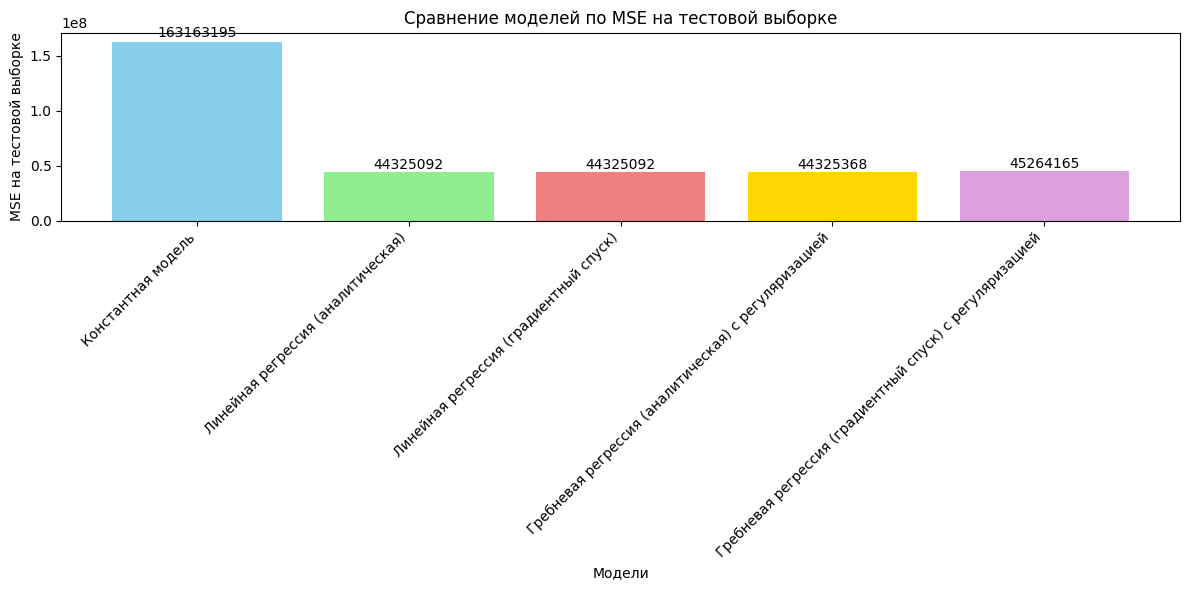

In [153]:
# Визуализация сравнения моделей
model_names = [name for name, _ in models]
mse_values = [mse for _, mse in models]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(model_names)), mse_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.xlabel('Модели')
plt.ylabel('MSE на тестовой выборке')
plt.title('Сравнение моделей по MSE на тестовой выборке')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')

# Добавление значений на столбцы
for i, (bar, value) in enumerate(zip(bars, mse_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
             f'{value:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()